In [1]:
import pandas as pd
import os
import pydpmd as dp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.colors import LogNorm
from scipy.optimize import minimize

def get_relaxation_time(f, t):
    tau = np.interp(1 / np.e, f[::-1], t[::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

def get_peak_location(r, g, window_pct=0.99):
    mask = g >= np.max(g) * window_pct
    return np.mean(r[mask])

def fit_log(_x, _y, n=1, min_cut_pct=None, max_cut_pct=None):
    mask = np.ones(_x.shape[0], dtype=bool)
    if min_cut_pct:
        mask &= (_x >= min_cut_pct * _x.max())
    if max_cut_pct:
        mask &= (_x <= max_cut_pct * _x.max())
    x = np.log10(_x[mask])
    y = np.log10(_y[mask])
    # fit the exponent
    n_measured, log_d = np.polyfit(x, y, 1)
    if n is None:
        d = 10 ** log_d
        y_pred = n_measured * x + log_d
    else:
        # fit the prefactor using the assumed exponent
        def obj(b, x, y):
            return np.sum((y - (n * x + b)) ** 2)
        log_d = minimize(obj, log_d, args=(x, y)).x[0]
        d = 10 ** log_d
        y_pred = n * x + log_d
    r2 = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)
    return d, n_measured, r2

In [36]:
unjam_root = '/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/'

df = {
    'nv': [],
    'mu': [],
    'phi': [],
    'delta_phi': [],
    'pressure': [],
    'temp': [],
    'msd': [],
    'msad': [],
    'isf_small': [],
    'isf_large': [],
    'angular_isf_small': [],
    'angular_isf_large': [],
    't': [],
    'g_small': [],
    'g_large': [],
    'r': [],
    'r0_small': [],
    'r0_large': [],
    'tau_small': [],
    'tau_large': [],
    'atau_small': [],
    'atau_large': [],
    'D': [],
    'aD': [],
    'n_obs': [],
    'an_obs': [],
    'DR2': [],
    'aDR2': [],
}

for root in tqdm(os.listdir(unjam_root)):
    if '.DS' in root:
        os.remove(os.path.join(unjam_root, root))
        continue

    for fname in os.listdir(os.path.join(unjam_root, root)):
        path = os.path.join(unjam_root, root, fname)
        if '.DS' in path:
            os.remove(path)
            continue
        try:
            data = dp.data.load(path, location=['final', 'init'])
            data.calculate_mu_eff()
            for i in range(data.n_systems()):
                g_small = data.final.g[i, 0]
                g_large = data.final.g[i, 1]
                msd = data.final.msd[:, i, 0]
                msad = data.final.msd[:, i, 1]
                isf_small = data.final.isf[:, 0, i]
                isf_large = data.final.isf[:, 1, i]
                angular_isf_small = data.final.angular_isf[:, 0, i]
                angular_isf_large = data.final.angular_isf[:, 1, i]
                t = data.final.t
                r = data.final.r

                D, n_obs, DR2 = fit_log(t, msd, n=1, min_cut_pct=0.1, max_cut_pct=0.9)
                aD, an_obs, aDR2 = fit_log(t, msad, n=1, min_cut_pct=0.1, max_cut_pct=0.9)
                df['D'].append(D)
                df['n_obs'].append(n_obs)
                df['DR2'].append(DR2)
                df['aD'].append(aD)
                df['an_obs'].append(an_obs)
                df['aDR2'].append(aDR2)
                
                tau_small = get_relaxation_time(isf_small, t)
                tau_large = get_relaxation_time(isf_large, t)
                df['tau_small'].append(tau_small)
                df['tau_large'].append(tau_large)

                atau_small = get_relaxation_time(angular_isf_small, t)
                atau_large = get_relaxation_time(angular_isf_large, t)
                df['atau_small'].append(atau_small)
                df['atau_large'].append(atau_large)

                r0_small = get_peak_location(r, g_small)
                r0_large = get_peak_location(r, g_large)
                df['r0_small'].append(r0_small)
                df['r0_large'].append(r0_large)
            df['nv'].extend(data.n_vertices_per_particle[data.system_offset[:-1]] - 1)
            df['mu'].extend(data.mu_eff[data.system_offset[:-1]])
            df['phi'].extend(data.packing_fraction)
            df['delta_phi'].extend(data.delta_phi)
            df['pressure'].extend(data.final.mean_pressure)
            df['temp'].extend(data.final.mean_temperature)
            df['msd'].extend(data.final.msd[..., 0].T)
            df['msad'].extend(data.final.msd[..., 1].T)
            df['isf_small'].extend(data.final.isf[:, 0, :].T)
            df['isf_large'].extend(data.final.isf[:, 1, :].T)
            df['angular_isf_small'].extend(data.final.angular_isf[:, 0, :].T)
            df['angular_isf_large'].extend(data.final.angular_isf[:, 1, :].T)
            df['t'].extend([data.final.t for _ in range(data.n_systems())])
            df['g_small'].extend(data.final.g[:, 0])
            df['g_large'].extend(data.final.g[:, 1])
            df['r'].extend([data.final.r for _ in range(data.n_systems())])
        except Exception as e:
            print(f'Error on path: "{path}" : {e}')

df = pd.DataFrame(df)

  0%|          | 0/30 [00:00<?, ?it/s]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.1-nv-11/delta_phi-2.000e-01" : g


  3%|▎         | 1/30 [00:01<00:52,  1.80s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.05-nv-13/delta_phi-2.000e-01" : g


  7%|▋         | 2/30 [00:03<00:50,  1.79s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.1-nv-19/delta_phi-2.000e-01" : g


 10%|█         | 3/30 [00:05<00:48,  1.79s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.01-nv-13/delta_phi-2.000e-01" : g


 13%|█▎        | 4/30 [00:07<00:47,  1.83s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.5-nv-19/delta_phi-2.000e-01" : g


 17%|█▋        | 5/30 [00:09<00:45,  1.81s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.5-nv-11/delta_phi-2.000e-01" : g


 20%|██        | 6/30 [00:10<00:42,  1.76s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.01-nv-31/delta_phi-2.000e-01" : g


 23%|██▎       | 7/30 [00:12<00:43,  1.88s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.05-nv-5/delta_phi-2.000e-01" : g


 27%|██▋       | 8/30 [00:14<00:39,  1.81s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.01-nv-7/delta_phi-2.000e-01" : g


 30%|███       | 9/30 [00:16<00:37,  1.81s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-1.0-nv-7/delta_phi-2.000e-01" : g


 33%|███▎      | 10/30 [00:17<00:35,  1.77s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.05-nv-31/delta_phi-2.000e-01" : g


 37%|███▋      | 11/30 [00:19<00:34,  1.82s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.1-nv-5/delta_phi-2.000e-01" : g


 40%|████      | 12/30 [00:21<00:31,  1.76s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.5-nv-7/delta_phi-2.000e-01" : g


 43%|████▎     | 13/30 [00:23<00:29,  1.73s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-1.0-nv-11/delta_phi-2.000e-01" : g


 47%|████▋     | 14/30 [00:24<00:27,  1.70s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-1.0-nv-19/delta_phi-2.000e-01" : g


 50%|█████     | 15/30 [00:26<00:25,  1.72s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.05-nv-11/delta_phi-2.000e-01" : g


 53%|█████▎    | 16/30 [00:28<00:24,  1.74s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-1.0-nv-31/delta_phi-2.000e-01" : g


 57%|█████▋    | 17/30 [00:30<00:23,  1.79s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.05-nv-19/delta_phi-2.000e-01" : g


 60%|██████    | 18/30 [00:32<00:21,  1.80s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.1-nv-13/delta_phi-2.000e-01" : g


 63%|██████▎   | 19/30 [00:33<00:19,  1.78s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.01-nv-19/delta_phi-2.000e-01" : g


 67%|██████▋   | 20/30 [00:35<00:18,  1.83s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.5-nv-13/delta_phi-2.000e-01" : g


 70%|███████   | 21/30 [00:37<00:16,  1.79s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.01-nv-11/delta_phi-2.000e-01" : g


 73%|███████▎  | 22/30 [00:39<00:14,  1.81s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-1.0-nv-5/delta_phi-2.000e-01" : g


 77%|███████▋  | 23/30 [00:40<00:12,  1.76s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.05-nv-7/delta_phi-2.000e-01" : g


 80%|████████  | 24/30 [00:42<00:10,  1.78s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.01-nv-5/delta_phi-2.000e-01" : g


 83%|████████▎ | 25/30 [00:44<00:08,  1.80s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.5-nv-31/delta_phi-2.000e-01" : g


 87%|████████▋ | 26/30 [00:46<00:07,  1.81s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.1-nv-31/delta_phi-2.000e-01" : g


 90%|█████████ | 27/30 [00:48<00:05,  1.83s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-1.0-nv-13/delta_phi-2.000e-01" : g


 93%|█████████▎| 28/30 [00:50<00:03,  1.79s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.1-nv-7/delta_phi-2.000e-01" : g


 97%|█████████▋| 29/30 [00:51<00:01,  1.75s/it]

Error on path: "/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-16-25/dynamics/rb-medium/T-1.000e-05/mu-0.5-nv-5/delta_phi-2.000e-01" : g


100%|██████████| 30/30 [00:53<00:00,  1.78s/it]


There seems to be two different slopes in the pressure vs delta phi graph.  Before this, we have a 0-slope solid.  Then, we get a shallow slope liquid, likely with caged translations and free rotations.  Then, we get a steeper slope liquid, likely with free translations and rotations.  It seems that this two-step behavior can be linked to the rotational and translational relaxation times, as well as the inwards shift in r0.

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_90660/2718757875.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(_df.delta_phi, _df.pressure, s=1, c=cmap(mu_norm(mu)))


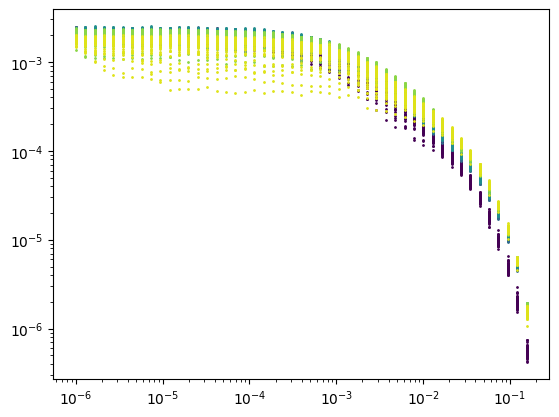

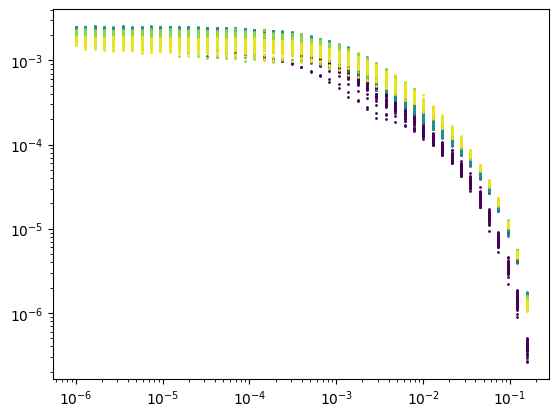

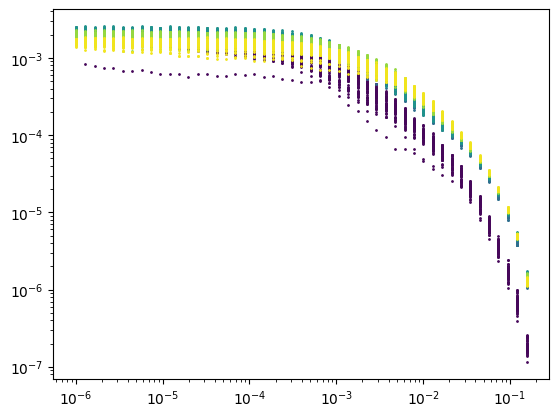

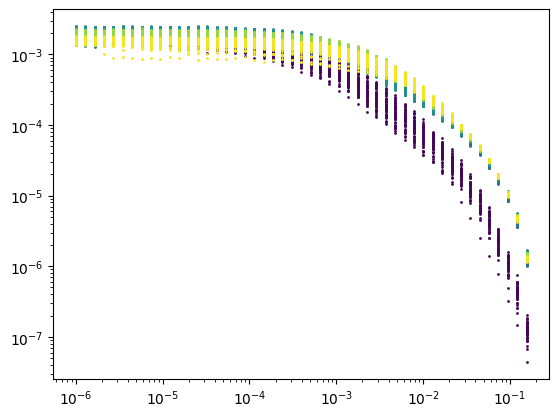

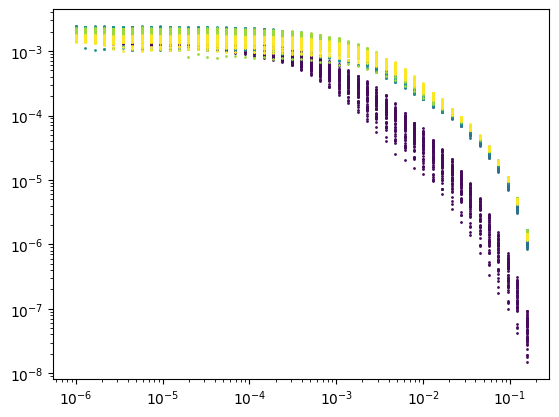

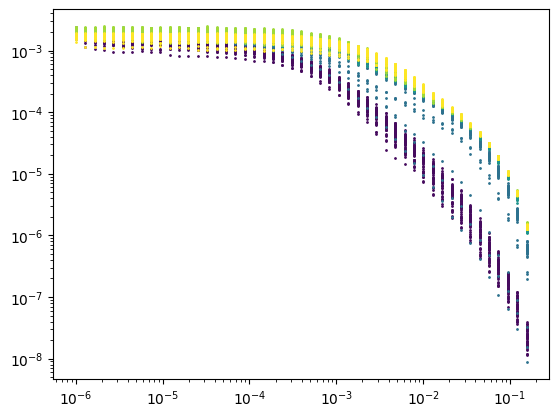

In [38]:
mu_norm = LogNorm(vmin=df.mu.min(), vmax=df.mu.max())
cmap = plt.cm.viridis

for nv in np.unique(df.nv):
    for mu in np.unique(df.mu[df.nv == nv]):
        _df = df[(df.nv == nv) & (df.mu == mu)]
        plt.scatter(_df.delta_phi, _df.pressure, s=1, c=cmap(mu_norm(mu)))
    plt.yscale('log')
    plt.xscale('log')
    plt.show()

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_90660/1991946608.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(_df.delta_phi, _df.tau_small, s=1, c=cmap(mu_norm(mu)))
/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_90660/1991946608.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(_df.delta_phi, _df.atau_small, s=1, c=cmap(mu_norm(mu)))


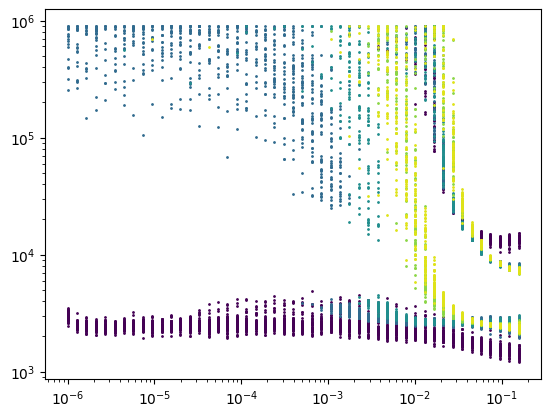

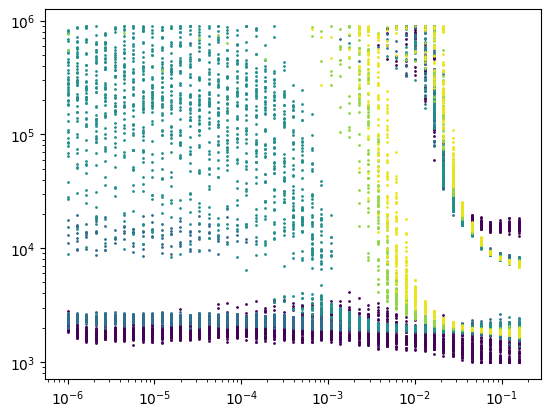

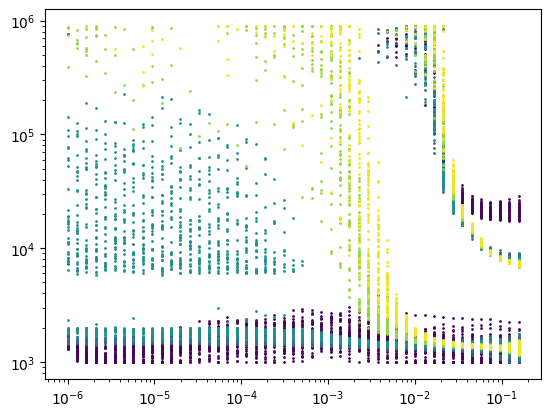

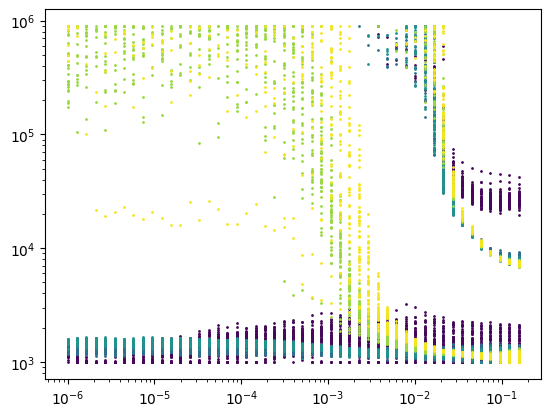

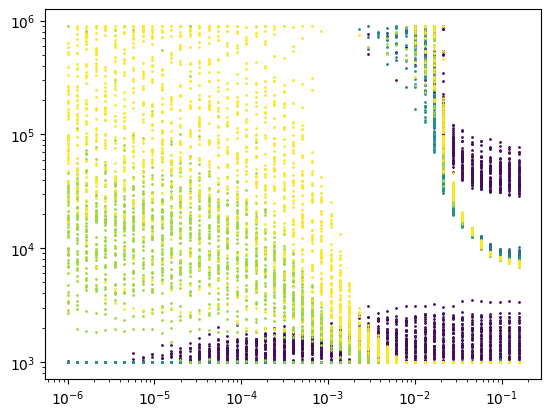

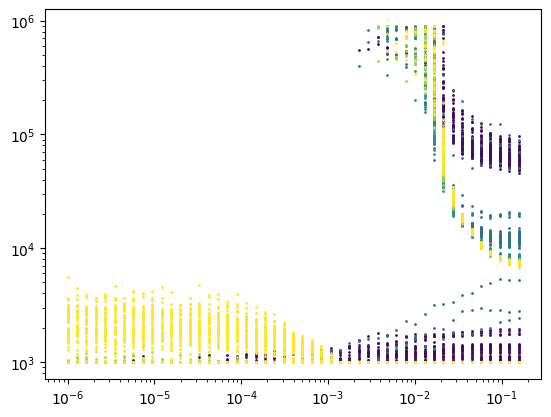

In [40]:
mu_norm = LogNorm(vmin=df.mu.min(), vmax=df.mu.max())
cmap = plt.cm.viridis

for nv in np.unique(df.nv):
    for mu in np.unique(df.mu[df.nv == nv]):
        _df = df[(df.nv == nv) & (df.mu == mu)]
        plt.scatter(_df.delta_phi, _df.tau_small, s=1, c=cmap(mu_norm(mu)))
        plt.scatter(_df.delta_phi, _df.atau_small, s=1, c=cmap(mu_norm(mu)))
    plt.yscale('log')
    plt.xscale('log')
    plt.show()

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_90660/1581488893.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(_df.delta_phi, _df.D, s=1, c=cmap(mu_norm(mu)))
/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_90660/1581488893.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(_df.delta_phi, _df.aD, s=1, c=cmap(mu_norm(mu)))


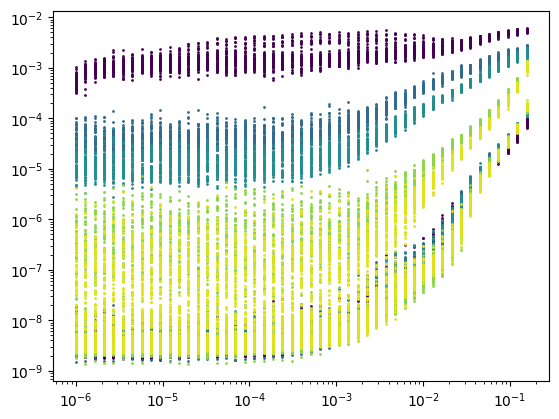

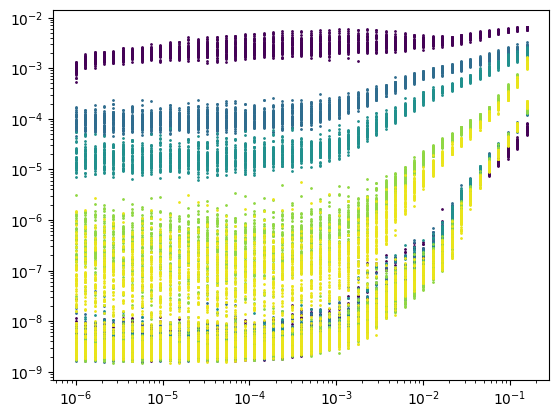

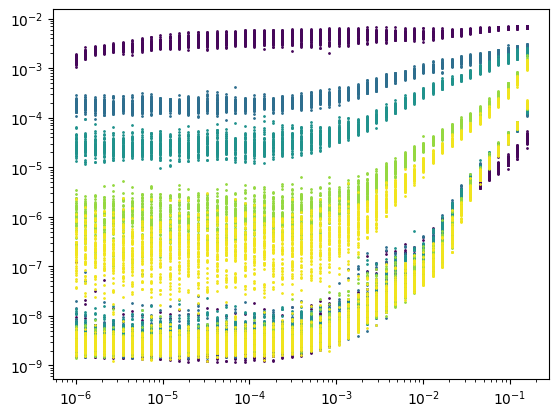

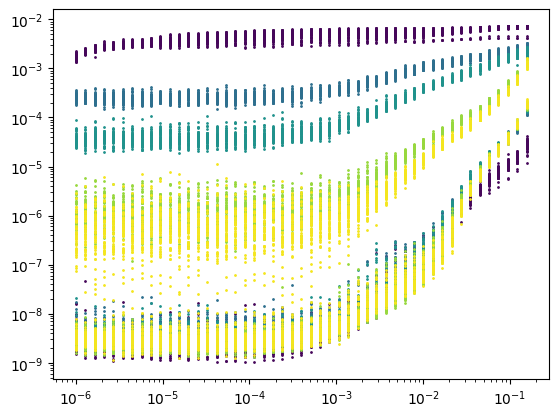

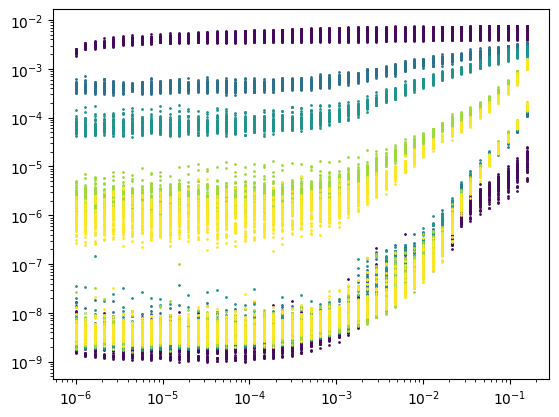

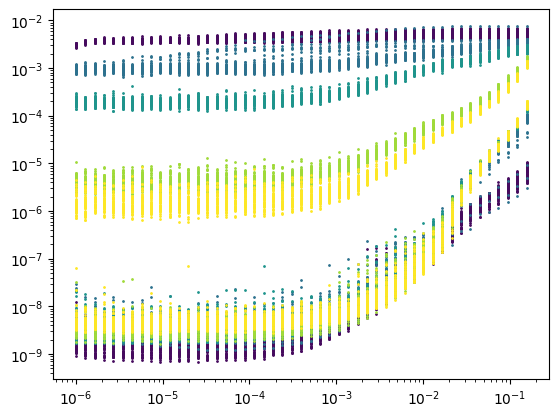

In [42]:
mu_norm = LogNorm(vmin=df.mu.min(), vmax=df.mu.max())
cmap = plt.cm.viridis

for nv in np.unique(df.nv):
    for mu in np.unique(df.mu[df.nv == nv]):
        _df = df[(df.nv == nv) & (df.mu == mu)]
        plt.scatter(_df.delta_phi, _df.D, s=1, c=cmap(mu_norm(mu)))
        plt.scatter(_df.delta_phi, _df.aD, s=1, c=cmap(mu_norm(mu)))
    plt.yscale('log')
    plt.xscale('log')
    plt.show()

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_90660/1894061595.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(_df.delta_phi, _df.r0_small, s=1, c=cmap(mu_norm(mu)))
/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_90660/1894061595.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(_df.delta_phi, _df.r0_large, s=1, c=cmap(mu_norm(mu)))


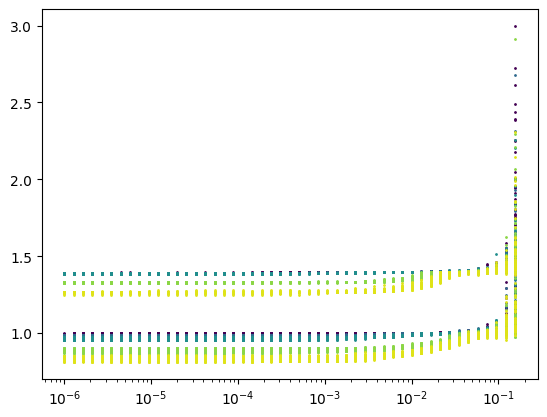

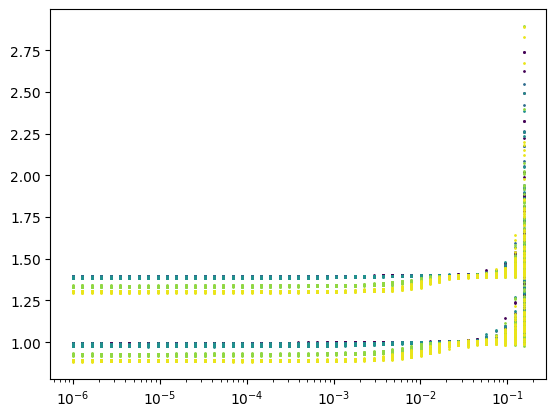

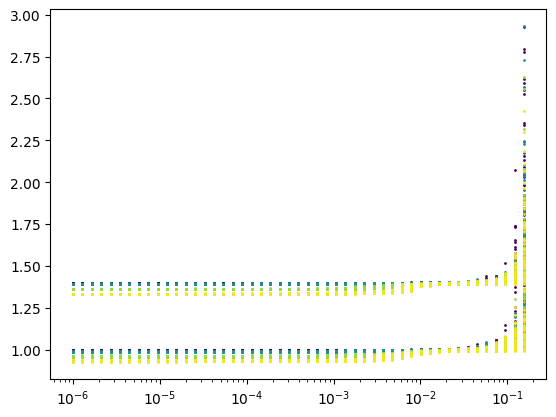

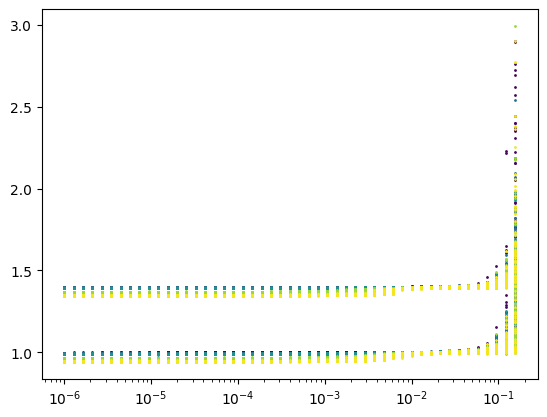

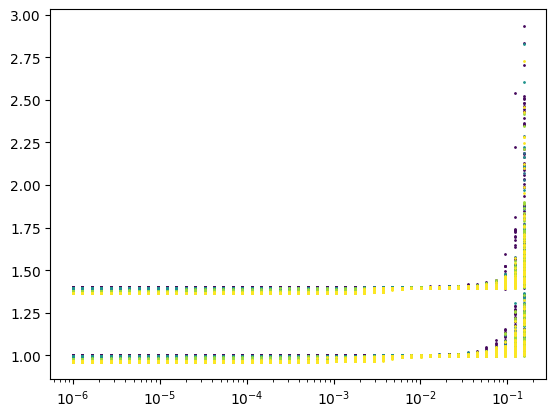

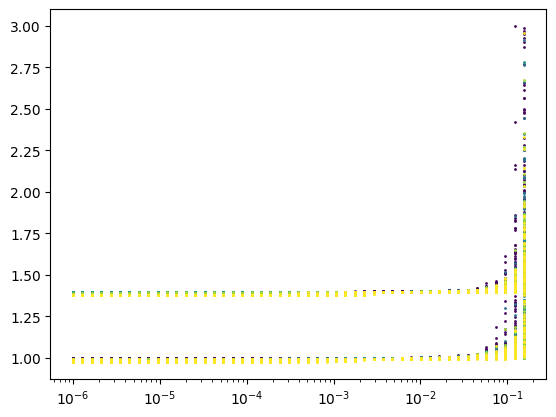

In [44]:
mu_norm = LogNorm(vmin=df.mu.min(), vmax=df.mu.max())
cmap = plt.cm.viridis

for nv in np.unique(df.nv):
    for mu in np.unique(df.mu[df.nv == nv]):
        _df = df[(df.nv == nv) & (df.mu == mu)]
        plt.scatter(_df.delta_phi, _df.r0_small, s=1, c=cmap(mu_norm(mu)))
        plt.scatter(_df.delta_phi, _df.r0_large, s=1, c=cmap(mu_norm(mu)))
    plt.xscale('log')
    plt.show()

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_90660/2691015261.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(_df.r0_small - _df.r0_small.values[i], _df.atau_small, s=1, c=cmap(mu_norm(mu)))


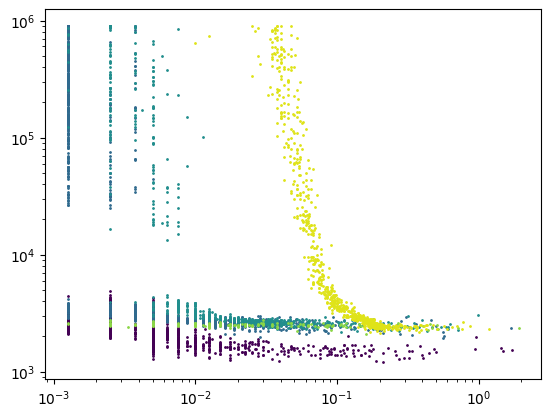

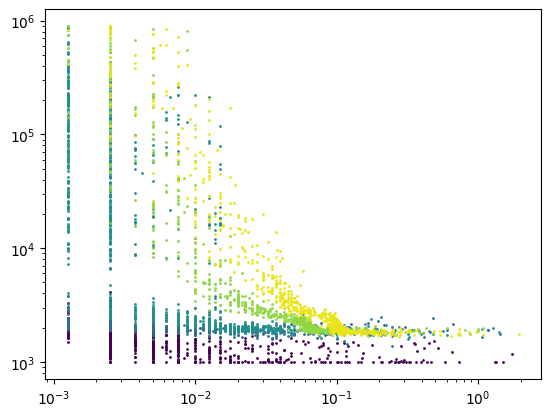

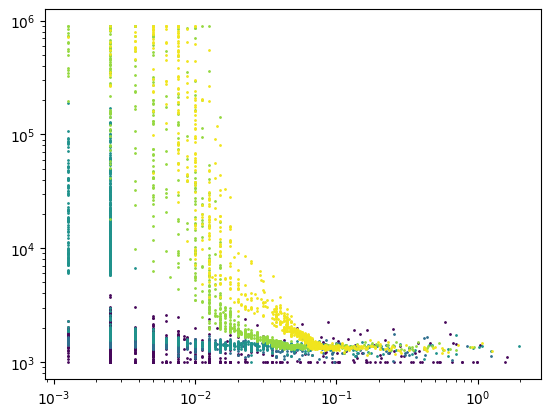

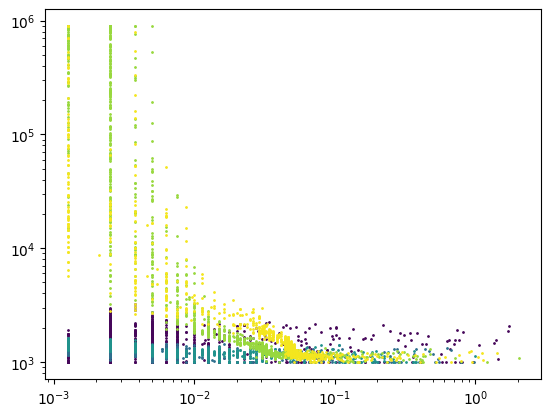

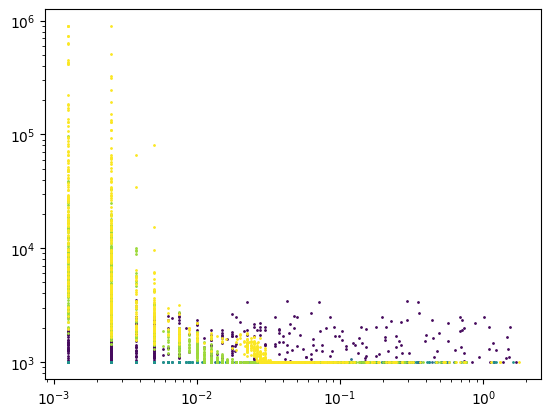

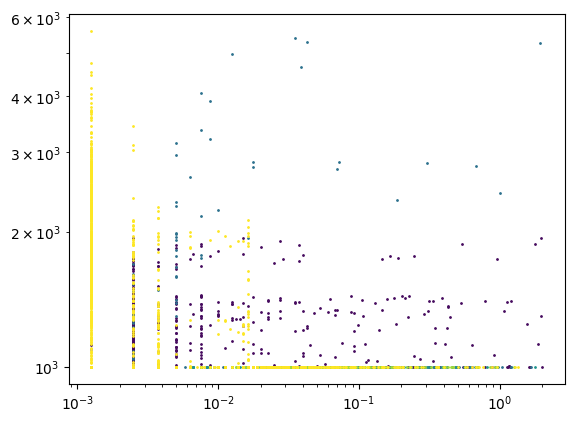

In [34]:
mu_norm = LogNorm(vmin=df.mu.min(), vmax=df.mu.max())
cmap = plt.cm.viridis

for nv in np.unique(df.nv):
    for mu in np.unique(df.mu[df.nv == nv]):
        _df = df[(df.nv == nv) & (df.mu == mu)]
        # i = _df.phi.values.argmax()
        i = _df.phi[~np.isnan(_df.atau_small)].values.argmax()
        plt.scatter(_df.r0_small - _df.r0_small.values[i], _df.atau_small, s=1, c=cmap(mu_norm(mu)))
    plt.yscale('log')
    plt.xscale('log')
    plt.show()